# Introduction to LSTMs with Keras
## IADS Summer School, 2nd August 2021

### Dr Michael Fairbank, University of Essex, UK

- Email: m.fairbank@essex.ac.uk
- This is Jupyter Notebook 2.2 of the course

## Max-Min time sequence (revisited)
We'll use the same dataset as before, but this time we'll use a long time_sequence_length (to make it harder).  This will motivate the introduction of LSTMs.

In [20]:
import numpy as np

time_sequence_length=60 # Longer time sequence than before (to make this problem harder)
training_set_size=10000
epochs=30
x_train=np.random.rand(training_set_size,time_sequence_length) # builds a matrix of random floats in [0,1)
x_train=x_train*2-1 # rescales numbers to be between -1 and +1
x_train=x_train*(np.random.rand(training_set_size,1)+0.5) # rescales each row so each row has a different range.  Uses broadcasting to make this multiplication work.
x_train=x_train+(np.random.rand(training_set_size,1)*2-1) # shifts the mean of each row. Uses broadcasting.
y_train=np.stack([np.max(x_train, axis=1),np.min(x_train, axis=1)],axis=1) # This finds the maximum of each row.

- We can check these numpy arrays are doing what they should.  First print sample 0 and its labels:

In [21]:
print("x_train, sample 0",x_train[0]) # This is the first training list of numbers
print("y_train, sample 0",y_train[0]) # This should show the max and min

x_train, sample 0 [ 0.32116246 -0.52957432 -0.93377436 -0.46906274 -0.68082338 -0.54110417
 -0.42076286  0.61081712  0.41634038 -0.12115138  0.6198787  -0.23864639
  0.43903823 -0.84664769  0.50543361  0.01412869 -0.35621574 -0.08905062
 -0.06694192  0.12170168 -0.84704932  0.4545934   0.49246575 -0.76508928
 -0.4128079  -0.21974212 -0.22877849 -0.18524984  0.58348306 -0.64465852
  0.27963832  0.43077721 -0.72187467 -0.38350002 -0.06143745 -0.86765131
 -0.77830356  0.24434558  0.13566132 -0.43921231 -0.89824956 -0.69506804
  0.07009086 -0.5300767   0.37226584  0.37869669  0.52403377 -0.44448152
  0.38688263  0.66460739 -0.76537528  0.40405638 -0.51734334 -0.71624589
  0.3934884  -0.50241272  0.70384127  0.39871896 -0.59137418 -0.76800124]
y_train, sample 0 [ 0.70384127 -0.93377436]


In [22]:
#Reshape the data as required for a Keras RNN:...
input_vector_length=1
print(x_train.shape)
x_train=x_train.reshape(training_set_size,time_sequence_length,input_vector_length).astype(np.float32)
print(x_train.shape)

output_vector_length=2 
print(y_train.shape)
y_train=y_train.reshape(training_set_size,output_vector_length).astype(np.float32)
print(y_train.shape)


(10000, 60)
(10000, 60, 1)
(10000, 2)
(10000, 2)


## Build a LSTM RNN to process this input tensor

Now we will use Keras to build a LSTM recurrent neural network to process a time sequence.

- LSTMs were created by Sepp Hochreiter and Jürgen Schmidhuber in 1997, to try to solve the problem of the hidden-vector's information decaying in long time-sequences in RNNs.  Hence the name "Long Short Term Memory" (LSTM).

- LSTMs are still RNNs - they are not something different!

- They use extra "memory gates" to make it harder for information to get erased from the recurrent hidden nodes.

- Letting information be held onto for longer like this stops learning process from getting stuck.  Hochreiter and Schmidhuber refer to it as solving the "vanishing gradients" problem, which refers to solving the fact that learning gradients decay rapidly in deep simpleRNNs.

The code below has similarities to the previous hand-built RNN, but with LSTM enhancements:

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
class HandBuiltLSTMModel(keras.Model):
    def __init__(self, num_hidden_nodes,  num_outputs):
        super(HandBuiltLSTMModel, self).__init__()
        self.num_hidden_nodes=num_hidden_nodes
        self.main_layer=layers.Dense(self.num_hidden_nodes*4,activation=None)
        self.output_layer=layers.Dense(num_outputs)
        
    def call(self, inputs):
        x=inputs
        batch_size=inputs.shape[0]
        hidden_h=tf.fill([batch_size, self.num_hidden_nodes], 0.0)
        hidden_c=tf.fill([batch_size, self.num_hidden_nodes], 0.0)
        for t in range(time_sequence_length):
            x=tf.concat([inputs[:,t,:],hidden_h],axis=1)
            layer_output=self.main_layer(x)
            # The next line splits the layer_output tensor from shape [batch_size,self.num_hidden_nodes*4]
            # into 4 tensor variables, each of shape [batch_size,self.num_hidden_nodes]
            input_gate, new_value, forget_gate, output_gate = tf.split(value=layer_output, 
                        num_or_size_splits=4, axis=1)
            forget_bias_tensor = 1.0
            hidden_c = ((hidden_c * tf.sigmoid(forget_gate+forget_bias_tensor)) + 
                     (tf.sigmoid(input_gate) * tf.tanh(new_value)))
            hidden_h = tf.tanh(hidden_c) * tf.sigmoid(output_gate)
        output_tensor=self.output_layer(hidden_h)
        return output_tensor

model_handbuilt_lstm = HandBuiltLSTMModel(num_hidden_nodes=20, num_outputs=output_vector_length)

- This hand-built model executes the usual RNN loop, while also implementing the LSTM equations
- Note that the LSTM has 4 times as many weights as the simpleRNN - so will run slower per iteration.  See line 9 to see the *4.
- **Try this:** Study the LSTM equations (lines of code) above, and see if you can figure out how it is possible for the hidden state $c$ to be updated, and how the hidden state $h$ is a partial view of $c$
    - In understanding the LSTM equations, be aware of what the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function) is, and what its range is (i.e. what its maximum and minimum output values are).
    - Also note that in lines 25-27, the * operator means elementwise multiplication of two tensors.
- **Questions**: 
    - Why is the forget_gate_bias set to 1?  What effect will that have?  **Answer** TODO Para intentar estar siempre en la parte positiva de la funcion sigmoidal


In [24]:
# Try putting a single input into the network
print(model_handbuilt_lstm(x_train[0:1,:,:]))

tf.Tensor([[0.00896737 0.02674744]], shape=(1, 2), dtype=float32)


In [25]:
# Try putting a "batch" of 2 input vectors through the network
print(model_handbuilt_lstm(x_train[0:2,:,:]))

tf.Tensor(
[[ 0.00896736  0.02674745]
 [ 0.04457615 -0.22455907]], shape=(2, 2), dtype=float32)


## Training the neural network

So next we'll "train" the network, in the usual keras way...

In [26]:
model_handbuilt_lstm.compile(
    optimizer=keras.optimizers.Adam(0.01),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError(),
    # List of metrics to monitor
    metrics=[keras.metrics.MeanAbsoluteError()],
)

history_handbuilt_lstm = model_handbuilt_lstm.fit(
    x_train,
    y_train,
    batch_size=100,
    epochs=epochs
)

Epoch 1/30
100/100 [==============================] - 3s 5ms/step - loss: 0.1567 - mean_absolute_error: 0.3011
Epoch 2/30
100/100 [==============================] - 0s 5ms/step - loss: 0.0797 - mean_absolute_error: 0.2376
Epoch 3/30
100/100 [==============================] - 0s 5ms/step - loss: 0.0186 - mean_absolute_error: 0.1041
Epoch 4/30
100/100 [==============================] - 0s 5ms/step - loss: 0.0101 - mean_absolute_error: 0.0789
Epoch 5/30
100/100 [==============================] - 0s 5ms/step - loss: 0.0089 - mean_absolute_error: 0.0736
Epoch 6/30
100/100 [==============================] - 0s 5ms/step - loss: 0.0080 - mean_absolute_error: 0.0705
Epoch 7/30
100/100 [==============================] - 0s 5ms/step - loss: 0.0065 - mean_absolute_error: 0.0632
Epoch 8/30
100/100 [==============================] - 0s 5ms/step - loss: 0.0061 - mean_absolute_error: 0.0613
Epoch 9/30
100/100 [==============================] - 0s 5ms/step - loss: 0.0056 - mean_absolute_error: 0.0591
E

- Now the network is trained, the scatter plot should line up nicely along $y=x$...

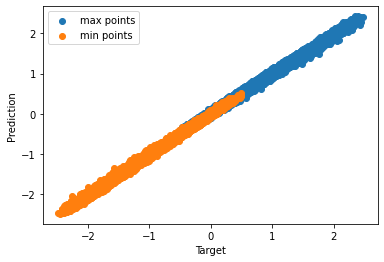

In [27]:
# Let's plot the model's current behaviour:
import matplotlib.pyplot as plt
plt.scatter(y_train[:,0],model_handbuilt_lstm(x_train).numpy()[:,0],label="max points")
plt.scatter(y_train[:,1],model_handbuilt_lstm(x_train).numpy()[:,1],label="min points")
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.legend()

 - The LSTM is solving the problem well even for the long time sequence!   

In [28]:
# Try putting a single input into the network
print(model_handbuilt_lstm(x_train[0:1,:,:]))
# And compare to the target min/max output
print(y_train[0:1,:])

tf.Tensor([[ 0.7265655 -0.9723742]], shape=(1, 2), dtype=float32)
[[ 0.70384127 -0.93377435]]


Text(0.5, 0, 'epoch')

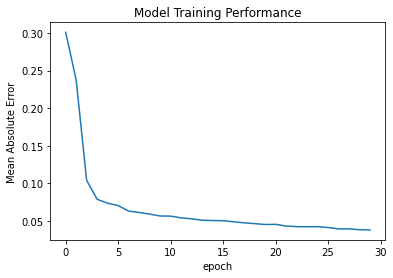

In [29]:
plt.plot(history_handbuilt_lstm.history['mean_absolute_error'])
plt.title('Model Training Performance')
plt.ylabel('Mean Absolute Error')
plt.xlabel('epoch')

## Using Built-in Keras LSTM layer
- The previous example showed how to build a LSTM-RNN by hand in Keras.  That exercise was just for educational purposes.
- Normally we'd use the LSTM keras layer to build a RNN like this.

<img src="./images/lstm_layer_network.svg"  width="600">

- The code and implementation is as it was for the SimpleRNN layer in the previous workbook; but we just swap "SimpleRNN" for "LSTM", in the following code block:

In [30]:
# Define Sequential LSTM model with 3 layers
model_keras_lstm = keras.Sequential(name="my_keras_lstm_network")
model_keras_lstm.add(layers.LSTM(20, activation='tanh',input_shape=(time_sequence_length,input_vector_length,)))
model_keras_lstm.add(layers.Dense(output_vector_length))
model_keras_lstm.summary()

Model: "my_keras_lstm_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 20)                1760      
                                                                 
 dense_8 (Dense)             (None, 2)                 42        
                                                                 
Total params: 1,802
Trainable params: 1,802
Non-trainable params: 0
_________________________________________________________________


As before, this model consumes a tensor of shape \[training_set_size,time_sequence_length,input_vector_length\] and outputs one of shape \[training_set_size,output_vector_length\]


In [31]:
model_keras_lstm.compile(
    optimizer=keras.optimizers.Adam(0.01),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError(),
    # List of metrics to monitor
    metrics=[keras.metrics.MeanAbsoluteError()],
)

history_keras_lstm = model_keras_lstm.fit(
    x_train,
    y_train,
    batch_size=100,
    epochs=epochs
)

Epoch 1/30
100/100 [==============================] - 2s 7ms/step - loss: 0.1633 - mean_absolute_error: 0.3119
Epoch 2/30
100/100 [==============================] - 1s 7ms/step - loss: 0.0856 - mean_absolute_error: 0.2458
Epoch 3/30
100/100 [==============================] - 1s 7ms/step - loss: 0.0423 - mean_absolute_error: 0.1588
Epoch 4/30
100/100 [==============================] - 1s 7ms/step - loss: 0.0110 - mean_absolute_error: 0.0817
Epoch 5/30
100/100 [==============================] - 1s 7ms/step - loss: 0.0092 - mean_absolute_error: 0.0748
Epoch 6/30
100/100 [==============================] - 1s 7ms/step - loss: 0.0087 - mean_absolute_error: 0.0728
Epoch 7/30
100/100 [==============================] - 1s 7ms/step - loss: 0.0075 - mean_absolute_error: 0.0674
Epoch 8/30
100/100 [==============================] - 1s 7ms/step - loss: 0.0066 - mean_absolute_error: 0.0640
Epoch 9/30
100/100 [==============================] - 1s 7ms/step - loss: 0.0061 - mean_absolute_error: 0.0616
E

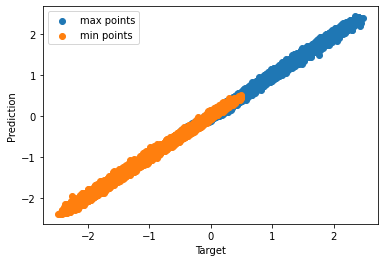

In [32]:
# Let's plot the model's current behaviour:
plt.scatter(y_train[:,0],model_keras_lstm(x_train).numpy()[:,0],label="max points")
plt.scatter(y_train[:,1],model_keras_lstm(x_train).numpy()[:,1],label="min points")
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.legend()

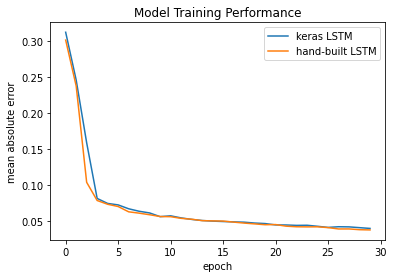

In [33]:
plt.plot(history_keras_lstm.history['mean_absolute_error'],label="keras LSTM")
plt.plot(history_handbuilt_lstm.history['mean_absolute_error'],label="hand-built LSTM")
plt.title('Model Training Performance')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend()

- Ok, we've shown the capabilities of the hand-built layer and the Keras LSTM layer nicely match.  

## Compare to SimpleRNN
- Let's check the performance using the LSTM really beats the SimpleRNN, which we'll rebuild again here for comparison...

In [34]:
# Define Sequential LSTM model with 3 layers
model_keras_simple_rnn = keras.Sequential()
model_keras_simple_rnn.add(layers.SimpleRNN(20, activation='tanh',input_shape=(time_sequence_length,input_vector_length,)))
model_keras_simple_rnn.add(layers.Dense(output_vector_length))

model_keras_simple_rnn.compile(
    optimizer=keras.optimizers.Adam(0.01),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError(),
    # List of metrics to monitor
    metrics=[keras.metrics.MeanAbsoluteError()],
)

history_keras_simple_rnn = model_keras_simple_rnn.fit(
    x_train,
    y_train,
    batch_size=100,
    epochs=epochs
)

Epoch 1/30
100/100 [==============================] - 1s 3ms/step - loss: 0.1637 - mean_absolute_error: 0.3114
Epoch 2/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0952 - mean_absolute_error: 0.2558
Epoch 3/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0813 - mean_absolute_error: 0.2317
Epoch 4/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0917 - mean_absolute_error: 0.2435
Epoch 5/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0596 - mean_absolute_error: 0.1931
Epoch 6/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0630 - mean_absolute_error: 0.1956
Epoch 7/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0429 - mean_absolute_error: 0.1626
Epoch 8/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0353 - mean_absolute_error: 0.1490
Epoch 9/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0354 - mean_absolute_error: 0.1473
E

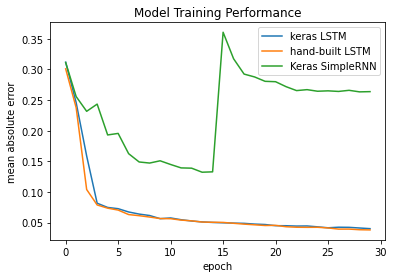

In [35]:
plt.plot(history_keras_lstm.history['mean_absolute_error'],label="keras LSTM")
plt.plot(history_handbuilt_lstm.history['mean_absolute_error'],label="hand-built LSTM")
plt.plot(history_keras_simple_rnn.history['mean_absolute_error'],label="Keras SimpleRNN")
plt.title('Model Training Performance')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend()

- The above graph shows that LSTM really performs a lot better than the SimpleRNN implementation, especially when time_sequence_length >> 10.

## Summary

- We've seen how an LSTM can learn longer time sequences more easily than a SimpleRNN can.
- We should understand that a LSTM is a RNN (but with sophisticated "memory gates" added).
- The LSTM's memory gates let it hold on to information for longer than a simple RNN can.


## Further reading - GRUs

- A [Gated Recurrent Unit](https://en.wikipedia.org/wiki/Gated_recurrent_unit) (GRU) is a simpler variant than the LSTM.  It has half the number of weights and roughly the same performance.  
- It can easily be implemented in Keras just by changing "SimpleRNN" to "GRU".
- See https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU 


- Look at the LSTM equations (written as equations instead of code) here https://en.wikipedia.org/wiki/Long_short-term_memory
    

## Further Exercise
- Change the SimpleRNN model above into a GRU model.  Compare its performance to the LSTM model.  **Try This**


In [36]:
# Define Sequential GRU model with 3 layers
model_keras_gru = keras.Sequential()
model_keras_gru.add(layers.GRU(20, activation='tanh',input_shape=(time_sequence_length,input_vector_length,)))
model_keras_gru.add(layers.Dense(output_vector_length))

model_keras_gru.compile(
    optimizer=keras.optimizers.Adam(0.01),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError(),
    # List of metrics to monitor
    metrics=[keras.metrics.MeanAbsoluteError()],
)

history_keras_gru = model_keras_gru.fit(
    x_train,
    y_train,
    batch_size=100,
    epochs=epochs
)

Epoch 1/30
100/100 [==============================] - 1s 7ms/step - loss: 0.1218 - mean_absolute_error: 0.2596
Epoch 2/30
100/100 [==============================] - 1s 7ms/step - loss: 0.0112 - mean_absolute_error: 0.0824
Epoch 3/30
100/100 [==============================] - 1s 7ms/step - loss: 0.0073 - mean_absolute_error: 0.0671
Epoch 4/30
100/100 [==============================] - 1s 7ms/step - loss: 0.0065 - mean_absolute_error: 0.0634
Epoch 5/30
100/100 [==============================] - 1s 7ms/step - loss: 0.0057 - mean_absolute_error: 0.0594
Epoch 6/30
100/100 [==============================] - 1s 7ms/step - loss: 0.0050 - mean_absolute_error: 0.0559
Epoch 7/30
100/100 [==============================] - 1s 7ms/step - loss: 0.0043 - mean_absolute_error: 0.0517
Epoch 8/30
100/100 [==============================] - 1s 7ms/step - loss: 0.0040 - mean_absolute_error: 0.0495
Epoch 9/30
100/100 [==============================] - 1s 7ms/step - loss: 0.0037 - mean_absolute_error: 0.0477
E

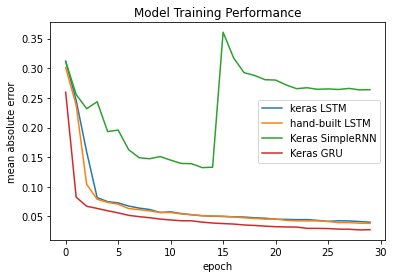

In [37]:
plt.plot(history_keras_lstm.history['mean_absolute_error'],label="keras LSTM")
plt.plot(history_handbuilt_lstm.history['mean_absolute_error'],label="hand-built LSTM")
plt.plot(history_keras_simple_rnn.history['mean_absolute_error'],label="Keras SimpleRNN")
plt.plot(history_keras_gru.history['mean_absolute_error'],label="Keras GRU")
plt.title('Model Training Performance')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend()